--- Loading dataset: iot23_500.csv ---
Data loaded successfully.

Dataset shape: (500, 21)
Removed identifier columns: ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p']

Encoded 5 target classes.
Fallback to non-stratified train-test split.
SVM model training completed.

Accuracy: 0.6267
Macro Precision: 0.6522
Macro Recall: 0.5192
Macro F1 Score: 0.5336

Classification Report:
                           precision    recall  f1-score   support

                   Benign       1.00      0.37      0.54        19
                     DDoS       1.00      0.82      0.90        17
                    Okiru       0.41      0.85      0.55        33
PartOfAHorizontalPortScan       0.85      0.56      0.67        81

                micro avg       0.66      0.63      0.64       150
                macro avg       0.82      0.65      0.67       150
             weighted avg       0.79      0.63      0.66       150



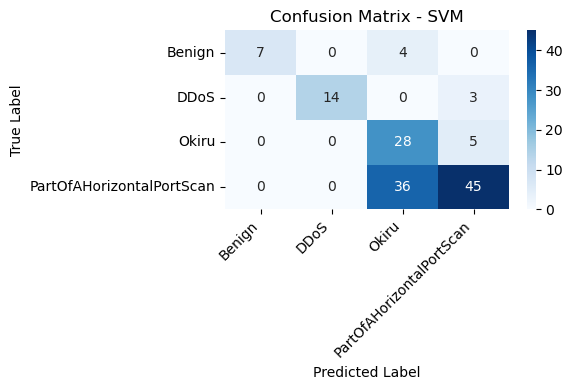


Generating fingerprint table...
Fingerprint table:
                             Benign       C&C      DDoS     Okiru  \
True_Label                                                          
Benign                     0.290868  0.006428  0.018678  0.163553   
DDoS                       0.036611  0.010105  0.749984  0.033742   
Okiru                      0.123568  0.007359  0.011993  0.347845   
PartOfAHorizontalPortScan  0.098514  0.005323  0.011328  0.208606   

                           PartOfAHorizontalPortScan  
True_Label                                            
Benign                                      0.520472  
DDoS                                        0.169559  
Okiru                                       0.509236  
PartOfAHorizontalPortScan                   0.676229  
Fingerprint table saved to 'svm_fingerprints.csv'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

data_file = 'iot23_500.csv'
fingerprint_output_file = 'svm_fingerprints.csv'

print(f"--- Loading dataset: {data_file} ---")
try:
    traffic_data = pd.read_csv(data_file)
    print("Data loaded successfully.")
    if 'Unnamed: 0' in traffic_data.columns:
        traffic_data = traffic_data.drop(columns=['Unnamed: 0'])
except FileNotFoundError:
    print(f"ERROR: File not found: {data_file}.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

print(f"\nDataset shape: {traffic_data.shape}")

# Drop identifier columns
identifier_columns = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p']
existing_ids_to_drop = [col for col in identifier_columns if col in traffic_data.columns]
working_data = traffic_data.drop(columns=existing_ids_to_drop)
print(f"Removed identifier columns: {existing_ids_to_drop}")

# Clean numeric and categorical features
numeric_features = [
    'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
]
numeric_features = [col for col in numeric_features if col in working_data.columns]

for col in numeric_features:
    if working_data[col].dtype == 'object':
        working_data[col] = working_data[col].replace('-', 0)
        working_data[col] = pd.to_numeric(working_data[col], errors='coerce').fillna(0)
    if not pd.api.types.is_numeric_dtype(working_data[col]):
        working_data[col] = working_data[col].astype(float)

text_features = ['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'history']
text_features = [col for col in text_features if col in working_data.columns]

for col in text_features:
    working_data[col] = working_data[col].fillna('-').astype(str)

if 'history' in text_features and working_data['history'].nunique() > 50:
    print("Dropping 'history' feature due to high cardinality.")
    text_features.remove('history')
    working_data = working_data.drop(columns=['history'])

# Separate features and target
features = working_data.drop(columns=['label'])
target_labels_text = working_data['label']

# Encode target labels
label_converter = LabelEncoder()
labels_numeric = label_converter.fit_transform(target_labels_text)
class_names = label_converter.classes_
print(f"\nEncoded {len(class_names)} target classes.")

# Define preprocessing pipeline
numeric_processor = Pipeline(steps=[('scaler', StandardScaler())])
text_processor = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
feature_processor = ColumnTransformer(
    transformers=[
        ('num_proc', numeric_processor, numeric_features),
        ('cat_proc', text_processor, text_features)
    ],
    remainder='passthrough'
)

# Train/test split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels_numeric, test_size=0.3, random_state=42, stratify=labels_numeric)
    print("Stratified train-test split completed.")
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels_numeric, test_size=0.3, random_state=42)
    print("Fallback to non-stratified train-test split.")

# Build SVM pipeline
model_pipeline = Pipeline(steps=[
    ('preprocess_features', feature_processor),
    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))
])
model_pipeline.fit(X_train, y_train)
print("SVM model training completed.")

# Evaluate model
predictions = model_pipeline.predict(X_test)
probabilities = model_pipeline.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro', zero_division=0)
recall = recall_score(y_test, predictions, average='macro', zero_division=0)
f1 = f1_score(y_test, predictions, average='macro', zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

print("\nClassification Report:")
present_labels_in_test = sorted(np.unique(y_test))
report_target_names = [class_names[i] for i in present_labels_in_test]
print(classification_report(y_test, predictions, labels=present_labels_in_test,
                            target_names=report_target_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, predictions, labels=present_labels_in_test)
plt.figure(figsize=(max(6, len(report_target_names)*0.6), max(4, len(report_target_names)*0.5)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names, yticklabels=report_target_names)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Generate fingerprint table
print("\nGenerating fingerprint table...")
try:
    proba_df = pd.DataFrame(probabilities, columns=class_names)
    true_labels_text_test = label_converter.inverse_transform(y_test)
    proba_df['True_Label'] = true_labels_text_test
    fingerprint_table = proba_df.groupby('True_Label').mean()
    print("Fingerprint table:")
    print(fingerprint_table)
    fingerprint_table.to_csv(fingerprint_output_file)
    print(f"Fingerprint table saved to '{fingerprint_output_file}'")
except Exception as e:
    print(f"Error during fingerprint table generation: {e}")
